# Spelling Correction of Children's Texts
In this notebook, Litkey Corpus will be analysed in order to get an overview of its' characteristics. Furthermore, the corpus will be preprocessed for further analysis (automatic spelling correction). Therefore, several versions of the corpus will be used throughout the notebook. The variants shall be explained in Chapter 1, Section 1.

- **Case sensitve is standard for analysis**

## Content

1. [Chapter 1 - The Data Sets](#1)
    * [0 - Data Load](#2)
    * [1 - Excerpts from Data Sets](#3)
        * [( I. ) Data_raw_token (unprocessed data set)](#17)
        * [( II. ) Data_clean_token (preprocessed data set)](#18)
        * [( III. ) Data_error_types (errors from preprocessed data set)](#19)
    * [2 - Size of Data Sets](#4)
2. [Chapter 2 - Data Analysis on Text Base](#5)
    * [1 - How long are the texts (histogram)?](#6)
    * [2 - Missspellings per Text](#7)
        * [a) Are there texts without any missspellings?](#8)
        * [b) How many missspellings are there per text (histogram)?](#9)
    * [3 - What is the error proportion (histogram)?](#10)
3. [Chapter 3 - Data Analysis on Error Base](#11)
    * [1 - Levenshtein Distance](#12)
        * [a) Cumulative Ratio](#13)
    * [2 - What are the most frequent 'original' and 'corrected' type?](#14)
    * [3 - Are there origs that are corrected to different targets?](#15)
    * [4 -  What are the different variants of missspellings of words?](#16)

<a id='1'></a><br>
# Chapter 1 - The Data Sets

In [1]:
# Import necessary libraries
import sys 
sys.path.insert(0, './Lisa')

import os
import fnmatch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.ticker import PercentFormatter
from nltk.metrics.distance import edit_distance

import glob
import csv
import random
import collections

import litkey_2
import helpers_litkey_2

# Do not truncate columns of DataFrame
pd.set_option('display.max_rows', None)

# Silence Silence SettingWithCopyWarning
# (occurs in stats on text level->2nd->before preprocessing)
pd.options.mode.chained_assignment = None

<a id='2'></a><br>
## 0 - Data Load

In [2]:
# Load necessary data sets
data_raw_token = litkey_2.load_raw(litkey_data_path = "./litkey-data/")
data_raw_types = litkey_2.load_raw(litkey_data_path = "./litkey-data/", toss_duplicates=True)

data_error_token = litkey_2.load(litkey_data_path = "./litkey-data/", toss_duplicates=False)
data_error_types = litkey_2.load(litkey_data_path = "./litkey-data/")

data_clean_token = litkey_2.load(keep_correct_words=True, toss_duplicates=False)

# Further data sets
data_clean_types = litkey_2.load(keep_correct_words=True)

data_clean_types_lc = litkey_2.load(lower_case=True, keep_correct_words=True)
data_error_types_lc = litkey_2.load(lower_case=True)

In [3]:
#data_clean_token.head(10)
#data_error_token.shape[0]
print(data_error_types_lc.shape[0])
print(data_error_types.shape[0])

8594
9484


In [4]:
# Export
data_raw_token.to_csv('./Lisa/datasets_litkey_export/data_raw_token_cs.csv', sep='|', index=False)
data_raw_types.to_csv('./Lisa/datasets_litkey_export/data_raw_types_cs.csv', sep='|', index=False)

data_error_token.to_csv('./Lisa/datasets_litkey_export/data_error_token_cs.csv', sep='|', index=False)
data_error_types.to_csv('./Lisa/datasets_litkey_export/data_error_types_cs.csv', sep='|', index=False)

data_clean_token.to_csv('./Lisa/datasets_litkey_export/data_clean_token_cs.csv', sep='|', index=False)
data_clean_types.to_csv('./Lisa/datasets_litkey_export/data_clean_types_cs.csv', sep='|', index=False)

<a id='3'></a><br>
## 1 - Excerpts from Data Sets 
There are mainly three versions of the data set that are frequently used in this notebook. The three are introduced in the following. Also, variants of these three data sets may occur.

<a id='17'></a><br>
### ( I. ) Data_raw_token (unprocessed data set)
For the analysis in this notebook, a version of the data set without preprocessing is needed. In this case, only NA-cases (line ends(^)) and headline markers (\h) are removed (as these have been added for annotation purposes). No other preprocessing did take place.

The head this version of the dataframe is shown below.


In [3]:
display(data_raw_token.head(20))

,original,corrected,filename
0,Lea,Lea,01-005-2-III-Eis.csv
1,und,und,01-005-2-III-Eis.csv
2,Lars,Lars,01-005-2-III-Eis.csv
3,und,und,01-005-2-III-Eis.csv
4,Dodo,Dodo,01-005-2-III-Eis.csv
5,gehen,gehen,01-005-2-III-Eis.csv
6,Eis,Eis,01-005-2-III-Eis.csv
7,kaufen,kaufen,01-005-2-III-Eis.csv
8,.,.,01-005-2-III-Eis.csv
9,Dodo,Dodo,01-005-2-III-Eis.csv


<a id='18'></a><br>
### ( II. ) Data_clean_token (preprocessed data set)
Now, the data set from above ( I. ) is preprocessed/cleaned. This includes ...
- ... that characters from normalization are removed, namely
    - "|" and "_", i. e. original is one/two-word whereas target is two/one-word
    - intended line-break characters '^', '-^', '^-'

- ... the exlucsion of some words from further analysis, namely
    - words containing illegible character(s), i. e. containing '*' (original)
    - non-words ('?' target not identifiable or no standardized spelling | '~' target non existing word form)
    - proper names ('Lea', 'Lars', 'Dodo') (corrected)
    - common abbreviations/words that contain a dot (corrected), also sentence boundaries
    - words less than 2 characters (corrected)
    
These measures result in corresponding head of data frame shown below (for comparison see ( I. )).

In [5]:
display(data_clean_token.head(20))

,original,corrected,filename,freq_ori,freq_cor,freq_tup
0,und,und,01-005-2-III-Eis.csv,9718,9827,9713
1,und,und,01-005-2-III-Eis.csv,9718,9827,9713
2,gehen,gehen,01-005-2-III-Eis.csv,288,377,288
3,Eis,Eis,01-005-2-III-Eis.csv,395,657,395
4,kaufen,kaufen,01-005-2-III-Eis.csv,53,80,53
5,belt,bellt,01-005-2-III-Eis.csv,91,256,91
6,den,den,01-005-2-III-Eis.csv,2401,2389,2278
7,Eismann,Eismann,01-005-2-III-Eis.csv,10,22,10
8,an,an,01-005-2-III-Eis.csv,1415,1440,1412
9,der,der,01-005-2-III-Eis.csv,3044,3049,3014


<a id='19'></a><br>
### ( III. ) Data_error_types (errors from preprocessed data set)
In addition to preprocessing steps in ( II. ), all correct words are not considered anymore. Only missspellings from litkey data set after preprocessing are kept.

Description of column names:
- *freq_ori*: how often does original appear in overall data set <br>
- *freq_cor*: how often does corrected appear in overall data set <br>
- *freq_tup*: how often does this tupel of (original, corrected) appear in overall data set

These measures result in corresponding head of data frame shown below (for comparison see ( II. ) and ( I. )).

In [6]:
display(data_error_token.head(20))

,original,corrected,filename,freq_ori,freq_cor,freq_tup
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73
2,dan,dann,01-005-2-III-Eis.csv,627,651,621
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14
5,felt,fällt,01-005-2-III-Eis.csv,93,198,90
6,wolte,wollte,01-005-2-III-Eis.csv,173,201,173
7,lekt,leckt,01-005-2-III-Eis.csv,20,42,19
8,fom,vom,01-005-2-III-Eis.csv,13,16,13
9,dan,dann,01-005-2-III-Eis.csv,627,651,621


To get a slight insight in possible missspellings in Litkey Corpus, a random sample is shown below.

In [7]:
data_error_types.sample(n=20, random_state=45) # random_state as random seed to reproduce chance

,original,corrected,filename,freq_ori,freq_cor,freq_tup
2952,veticht,fertig,04-135-3-II-Jenga.csv,1,43,1
6126,kaochen,Knochen,07-197-4-I-Schule.csv,1,15,1
4954,Aderese,Adresse,06-136-3-IV-Weg.csv,1,11,1
5651,rufft,ruft,06-607-3-IV-Weg.csv,1,15,1
5282,glingelt,klingelt,06-289-3-IV-Weg.csv,3,66,3
9326,Tör,Tür,10-436-4-IV-Weg.csv,1,15,1
5212,geklielt,geklingelt,06-253-3-IV-Weg.csv,1,13,1
9172,pisiert,passiert,10-286-4-IV-Weg.csv,1,75,1
4153,Jeds,Jetzt,05-236-3-III-Staubsauger.csv,5,27,2
593,zwa,zwar,01-307-2-III-Eis.csv,2,3,2


<a id='4'></a><br>
## 3 - Size of Data Sets
_The statistic is on tupel-base, i. e. one tupel consists of (original, corrected)-pair._
- data_raw_token: Contains all token that are contained in litkey data set
- data_clean_token: Contains all token, correct and incorrect tupel, that we are interested in for analysis
- data_error_token : Contains only the erroneous tupel out of "data_clean_token"

Vice versa with type base.

In [3]:
# Get frequency of token and types
data_raw_token_count = data_raw_token.shape[0]
data_clean_token_count = data_clean_token.shape[0]
data_error_token_count = data_error_token.shape[0]
#data_error_token_count = data_error_types['freq_tup'].sum(axis=0)

# Set ascending order for bar chart horizontal
label_barh = ["data_error_token", "data_clean_token", "data_raw_token"] # y axis
label_barh_types = ["data_error_types", "data_clean_types", "data_raw_types"]

data_barh = [data_error_token_count, data_clean_token_count, data_raw_token_count] # x axis
data_barh_types = [data_error_types.shape[0], data_clean_types.shape[0], data_raw_types.shape[0]]

#y_x_token = zip(label_barh, data_barh)
#y_x_types = zip(label_barh_types, data_barh_types)

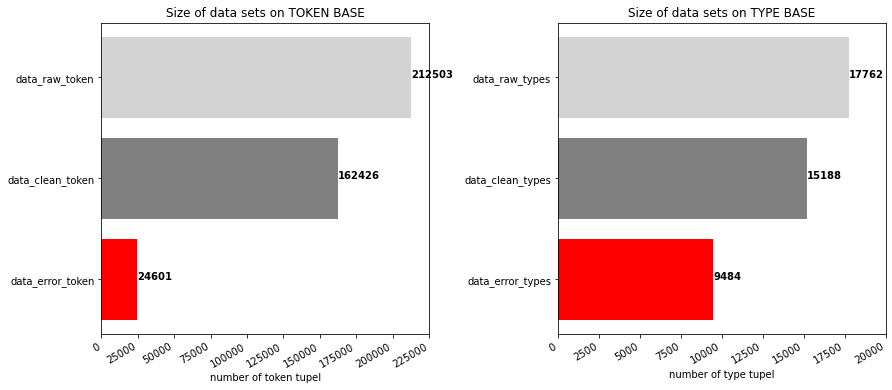

In [4]:
fig = plt.figure(figsize=(12.5,10))

def h_bar_chart(y_data, x_data, sub_pos=1):
    
    axs = fig.add_subplot(2,2,sub_pos)
        
    axs.barh(y_data, x_data, color=['red', 'gray', 'lightgray'])
    
    # Workaround
    label_format = '{.0f}'
    ticks_loc = axs.get_xticks().tolist()
    axs.set_xticks(ticks_loc)
    axs.set_xticklabels([int(x) for x in ticks_loc], rotation=30, ha='right')

    for index, value in enumerate(x_data):
        axs.text(value, index, str(value), fontweight='bold')
            
    return axs

axs_token = h_bar_chart(label_barh, data_barh, 1)
axs_types = h_bar_chart(label_barh_types, data_barh_types, 2)

axs_token.set_title("Size of data sets on TOKEN BASE")
axs_token.set_xlabel("number of token tupel")
axs_types.set_title("Size of data sets on TYPE BASE")
axs_types.set_xlabel("number of type tupel")

plt.tight_layout()
plt.show()

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > From 213 000 token in total, only 162 000 are of interest. From these 162 000 tokens, 25 000 tokens are erroneous. </span>

## 4 - What are the number of distinct taget words (corrected types)?

In [5]:
# for each data set
raw_corrected_types = data_raw_types.drop_duplicates(subset='corrected', keep='first')
clean_corrected_types = data_clean_types.drop_duplicates(subset='corrected', keep='first')
error_corrected_types = data_error_types.drop_duplicates(subset='corrected', keep='first')

In [12]:
corrected_types = [error_corrected_types, clean_corrected_types, raw_corrected_types]
# Convert list elements to string?
corrected_types_label = ["error_corrected_types", "clean_corrected_types", "raw_corrected_types"]

corrected_types_count = []
for e in corrected_types:
    corrected_types_count.append(e.shape[0])
    #print(e.shape[0])

In [7]:
#for df in corrected_types:
#    display(df[df.duplicated(subset='corrected', keep=False)])

In [13]:
print(corrected_types_count)

[3154, 5675, 6363]


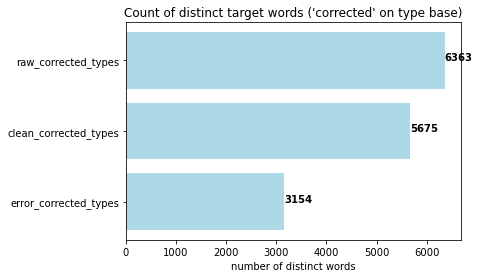

In [27]:
fig, ax = plt.subplots()
ax.barh(corrected_types_label, corrected_types_count, color='lightblue')
#sns.countplot(orient='h')
#plt.set_cmap('seismic')

for index, value in enumerate(corrected_types_count):
        ax.text(value, index, str(value), fontweight='bold')

ax.set_title("Count of distinct target words ('corrected' on type base)")
ax.set_xlabel("number of distinct words")

plt.show()

<a id='5'></a><br>
# Chapter 2 - Data Analysis on Text Base

<a id='6'></a><br>
## 1 - How long are the texts (histogram)?
Length per text is compared before (data_raw_token) and after preprocessing (data_clean_token).

In [11]:
# Define named tupel
Stats = collections.namedtuple('Stats', ['min','max','mean','std'])

def groupByFilename(df):
    df_grouped = df.groupby(['filename']).size()
    return df_grouped

def getStats(df_grouped, suppress_grouping=False):
    
    if suppress_grouping is False:
        df_grouped = df_grouped.groupby(['filename']).size()
    
    df_min = df_grouped.min()
    df_max = df_grouped.max()
    df_mean = round(df_grouped.mean(), 2)
    df_std = round(df_grouped.std(), 2)
    
    named_tupel = Stats(df_min, df_max, df_mean, df_std)
    
    return named_tupel

In [12]:
# Get histogram data
grouped_data_raw_token = groupByFilename(data_raw_token)
grouped_data_clean_token = groupByFilename(data_clean_token)

In [13]:
# Get stats for histogram
tupel_data_raw_token = getStats(data_raw_token)
tupel_data_clean_token = getStats(data_clean_token)

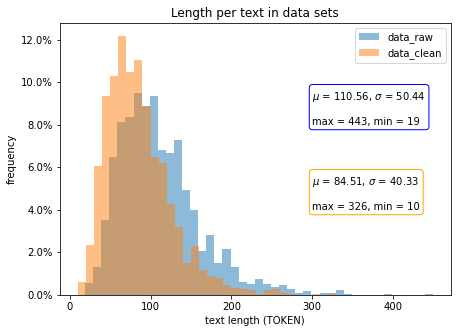

In [14]:
plt.figure(figsize=(7,5))
plt.hist(grouped_data_raw_token,
         weights = [1/len(grouped_data_raw_token)] * len(grouped_data_raw_token),
         bins=range(min(grouped_data_raw_token), max(grouped_data_raw_token) + 10,10),
         alpha=0.5,
         label = "data_raw")

plt.hist(grouped_data_clean_token,
         weights = [1/len(grouped_data_clean_token)] * len(grouped_data_clean_token),
         bins=range(min(grouped_data_clean_token), max(grouped_data_clean_token) + 10,10),
         alpha=0.5,
         label="data_clean")

plt.xlabel("text length (TOKEN)")
plt.ylabel("frequency")
plt.title("Length per text in data sets")
plt.legend(loc = 'upper right')

plt.text(300, 0.08, r'$\mu$ = '+str(tupel_data_raw_token.mean)+r', $\sigma$ = '+str(tupel_data_raw_token.std)
        +'\n\nmax = '+str(tupel_data_raw_token.max)+', min = '+str(tupel_data_raw_token.min), 
         bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round') )

plt.text(300, 0.04, r'$\mu$ = '+str(tupel_data_clean_token.mean)+r', $\sigma$ = '+str(tupel_data_clean_token.std)
        +'\n\nmax = '+str(tupel_data_clean_token.max)+', min = '+str(tupel_data_clean_token.min),
        bbox=dict(facecolor='none', edgecolor='orange', boxstyle='round') )

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > Distribution of text length is shiftet, texts contain fewer tokens in preprocessed version of data set than in raw version. Average of text length is reduced from 111 tokens in raw data to 85 in cleaned data. </span>

<a id='7'></a><br>
## 2 - Missspellings per Text

<a id='8'></a><br>
### a) Are there texts without any missspellings?

In [15]:
# COUNT TEXTS
number_texts = len(fnmatch.filter(os.listdir("./litkey-data"), '*.csv'))
print("Texts in total: "+str(number_texts))

Texts in total: 1922


In [16]:
# Wanted: Num. of files that are removed in step "Remove all correct words (ignoring case)
# Prefiltering: Check for filenames that are in data_raw, but not in data_error
data_raw_not_in_data = data_raw_token[~data_raw_token.filename.isin(data_error_types.filename)]

# Perform preprocessing steps on data_raw, extract errors

#data_raw_preprocessed_errors = litkey_2.load_raw(remove_characters_words=True, keep_correct_words=False)
data_clean_token_errors = litkey_2.load(keep_correct_words=False, toss_duplicates=False)

In [17]:
boolean_mask = data_raw_not_in_data.filename.isin(data_clean_token_errors.filename)
error_free = data_raw_not_in_data[~boolean_mask]

error_free_files = error_free.groupby(['filename']).size()
print("Texts without missspelling: "+str(error_free_files.shape[0]))

Texts without missspelling: 9


#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > There are 1922 texts in total from which 9 are without any missspellings. Therefore, words in analysis come from 1913 texts in total. </span>

<a id='9'></a><br>
### b) How many misspellings are there per text (histogram) ?
Number of missspellings per text is compared before (data_raw_token_errors) and after preprocessing (data_error_token).

In [18]:
# DATA_RAW
# TODO: Gibt es diesen df schon?
data_raw_token_errors = helpers_litkey_2.removeCorrectWords(data_raw_token)

In [19]:
# Get histogram data
grouped_data_raw_token_errors = groupByFilename(data_raw_token_errors)
grouped_data_error_token = groupByFilename(data_error_token)

In [20]:
# Get stats for histogram
tupel_data_raw_token_errors = getStats(data_raw_token_errors)
tupel_data_error_token = getStats(data_error_token)

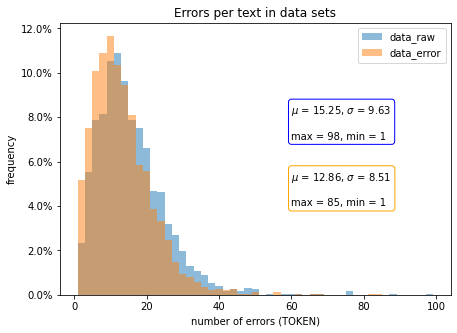

In [21]:
plt.figure(figsize=(7,5))
plt.hist(grouped_data_raw_token_errors,
         weights = [1/len(grouped_data_raw_token_errors)] * len(grouped_data_raw_token_errors),
         bins=range(min(grouped_data_raw_token_errors), max(grouped_data_raw_token_errors) + 2,2),
         alpha=0.5,
         label = "data_raw")

plt.hist(grouped_data_error_token,
         weights = [1/len(grouped_data_error_token)] * len(grouped_data_error_token),
         bins=range(min(grouped_data_error_token), max(grouped_data_error_token)+ 2,2),
         alpha=0.5,
         label="data_error")

plt.xlabel("number of errors (TOKEN)")
plt.ylabel("frequency")
plt.title("Errors per text in data sets")
plt.legend(loc = 'upper right')

plt.text(60, 0.07, r'$\mu$ = '+str(tupel_data_raw_token_errors.mean)+r', $\sigma$ = '+str(tupel_data_raw_token_errors.std)
        +'\n\nmax = '+str(tupel_data_raw_token_errors.max)+', min = '+str(tupel_data_raw_token_errors.min), 
         bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round') )

plt.text(60, 0.04, r'$\mu$ = '+str(tupel_data_error_token.mean)+r', $\sigma$ = '+str(tupel_data_error_token.std)
        +'\n\nmax = '+str(tupel_data_error_token.max)+', min = '+str(tupel_data_error_token.min),
        bbox=dict(facecolor='none', edgecolor='orange', boxstyle='round') )

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.show()

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > Distribution of errors per text is shiftet only slightly, texts contain fewer errors in preprocessed version of data set which contains only errors than in raw version of the data set. Average of errors per text is reduced from 15.25 tokens in data_raw to 12.86 in data_error. </span>

<a id='10'></a><br>
## 3 - What is the error proportion (histogram)?
Base: data_clean_token, data_error_token
- Ratio between erroneous words/all analyzed words, e. g. in average 24 % of the TOKENS missspelled

In [22]:
# Get data
grouped_data_clean_token = groupByFilename(data_clean_token)
grouped_data_error_token = groupByFilename(data_error_token)

ratio_errors_all_words = (grouped_data_error_token/grouped_data_clean_token)
ratio_errors_all_words.fillna(value=0, inplace=True)

# Get stats
tupel_ratio = getStats(ratio_errors_all_words, suppress_grouping=True)

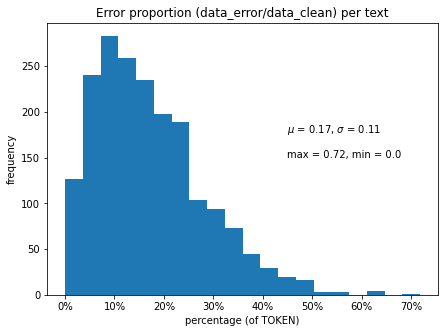

In [23]:
# Histogram
plt.figure(figsize=(7,5))
plt.hist(ratio_errors_all_words, bins=20)
plt.title("Error proportion (data_error/data_clean) per text")
plt.xlabel("percentage (of TOKEN)")
plt.ylabel("frequency")
plt.text(0.45, 150, r'$\mu$ = '+str(tupel_ratio.mean)+r', $\sigma$ = '+str(tupel_ratio.std)
        +'\n\nmax = '+str(round(tupel_ratio.max, 2))+', min = '+str(tupel_ratio.min))

# Data between 0 an 1

# To PercentFormatter (show proportion as percentage)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

plt.show()

# TODO: linksschief/rechtsschief?
# TODO: Quartile berechnen?
# nach Augenmaß

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > The ratio between erroneous words to all words analyzed, textwise, is on average 17%. That means that, on average, 17% of the analyzed words in a text is spelled incorrectly. The distribution decreases in direction to higher percentages steadily, maximum is 72%. Distribution decreases also in direction to lower percentages. Minimum is 0%, indicating there are some texts without any errors (see 1.2)). Main part of error proportion is between 5% and 25%. </span>

<a id='11'></a><br>
# Chapter 3 - Data Analysis on Error Base

<a id='12'></a><br>
## 2 - Levenshtein Distance
- between original and target word
- consideration of case sensitive and case insensitive
- on type- and tokenbase

tuple: (original, corrected)-Pair

In [24]:
# Get Levenshtein distance stats
data_error_types['distance'] = data_error_types.apply(lambda r: edit_distance(r.original, r.corrected), axis=1)

# Same for case insenstive
data_error_types_lc['distance'] = data_error_types_lc.apply(lambda r: edit_distance(r.original, r.corrected), axis=1)

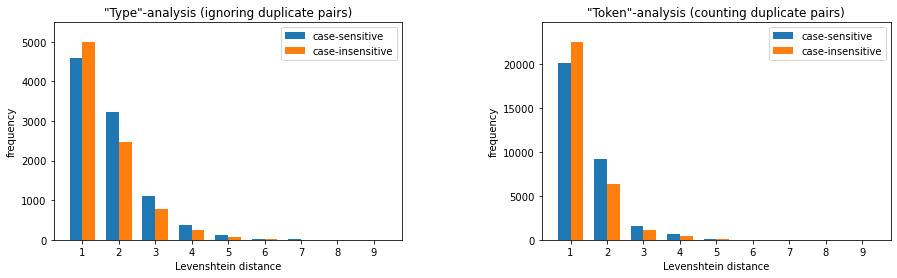

In [25]:
# Plot
fig = plt.figure()
ax1 = fig.add_subplot(121) # 1row, 2columns, 1st position
ax2 = fig.add_subplot(122) # 1row, 2columns, 2nd position

x = np.arange(9) # position of bars on x-axis
width = 0.35 # width of the bars

# FOR CUMULATIVE RATIO
#ax1_cum = ax1.twinx()
#ax2_cum = ax2.twinx()

#ax1_cum.plot(range(-1, 9), [0] + data.distance.value_counts(True).cumsum().tolist(), 'k.-')
#ax1_cum.set_ylabel('Cumulative ratio')
#ax2_cum.plot(range(-1, 9), [0] + (a / a.sum()).cumsum().tolist(), 'k.-')
#ax2_cum.set_ylabel('Cumulative ratio')

#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)

fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# TYPE - CASE SENSITIVE
a = data_error_types.distance.value_counts().max()
rects1 = ax1.bar(x-width/2, data_error_types.groupby('distance').size(), width, label='case-sensitive')
#ax1.set_ylim(0, 1.1*a)

ax1.set_xticks(range(-1, 9))
ax1.set_xticklabels([''] + list(range(1, 10)))

ax1.set_ylabel('frequency')
ax1.set_xlabel('Levenshtein distance')
ax1.set_title('"Type"-analysis (ignoring duplicate pairs)')

# TYPE - CASE INSENSITIVE
b = data_error_types_lc.distance.value_counts().max()
rects2 = ax1.bar(x+width/2, data_error_types_lc.groupby('distance').size(), width, label='case-insensitive')

ax1.set_ylim(0, 1.1*b)

ax1.legend()


# TOKEN - CASE SENSITIVE
c = data_error_types.groupby('distance').freq_ori.sum()
rects1 = ax2.bar(x-width/2, c, width, label='case-sensitive')
#ax2.set_ylim(0, 1.1*a.max())

ax2.set_xticks(range(-1, 9))
ax2.set_xticklabels([''] + list(range(1, 10)))

ax2.set_ylabel('frequency')
ax2.set_xlabel('Levenshtein distance')
ax2.set_title('"Token"-analysis (counting duplicate pairs)')

# TOKEN - CASE INSENSITIVE
d = data_error_types_lc.groupby('distance').freq_ori.sum()
rects2 = ax2.bar(x+width/2, d, width, label='case-insensitive')

ax2.set_ylim(0, 1.1*d.max())

ax2.legend()

#fig.tight_layout()
plt.show()

# TODO: Wording überdenken

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > Comparing between type- and token-analysis, distribution of Levenshtein distance looks similar, more frequency in general in token-analysis. Levenshtein distance 1 is most frequent. Here, case-insensitive has a higher frequency compared to case-sensitive. In all other Levenshtein distances, case-sensitive has a higher frequency than case-insensitive. Looking at type-analysis, with Levenshtein distance 1-3 most cases are catched, with 1-4 there are only few cases left (meaning there are few words with higher Levensthein distance). </span>

<a id='13'></a><br>
### a) Cumulative Ratio

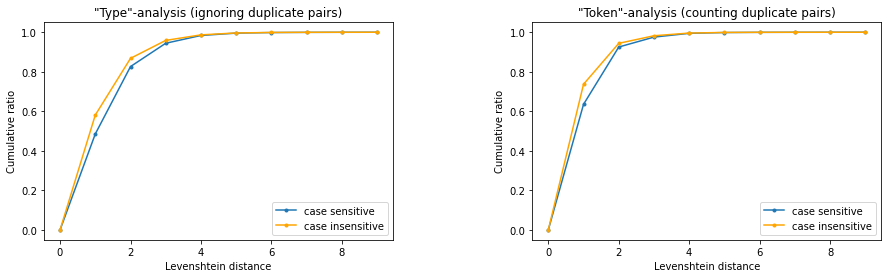

In [26]:
# Plot
fig = plt.figure()
ax1 = fig.add_subplot(121) # 1row, 2columns, 1st position
ax2 = fig.add_subplot(122) # 1row, 2columns, 2nd position

width = 0.35 # width of the bars

ax1.plot(range(0, 10), [0] + data_error_types.distance.value_counts(True).cumsum().tolist(), '.-', label='case sensitive')
ax1.plot(range(0, 10), [0] + data_error_types_lc.distance.value_counts(True).cumsum().tolist(), '.-', color='orange', label='case insensitive')
ax1.set_ylabel('Cumulative ratio')

ax2.plot(range(0, 10), [0] + (c / c.sum()).cumsum().tolist(), '.-', label='case sensitive')
ax2.plot(range(0, 10), [0] + (d / d.sum()).cumsum().tolist(), '.-', color='orange', label='case insensitive')
ax2.set_ylabel('Cumulative ratio')

ax1.set_title('"Type"-analysis (ignoring duplicate pairs)')
ax1.set_xlabel('Levenshtein distance')
ax2.set_title('"Token"-analysis (counting duplicate pairs)')
ax2.set_xlabel('Levenshtein distance')
#ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)
ax1.legend()
ax2.legend()

fig.set_figwidth(15)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > As indicated above, in both analysis nearly 100% types/tokens are catched with Levenshtein distance up to 4. Levenshtein distance up to 2 catches 80% in type-analysis, nearly 90% in token-analysis. Levenshtein distance 1 catches about 50% in type-analysis, 60%+ in token-anylsis. </span>

<a id='14'></a><br>
## 2 - What are the most frequent 'original' and 'corrected' type?
Based on data_error_types; Erroneous words (types), case sensitive, are considered.
- most frequent original (= missspelling)
- most frequent corrected (= target word)

In [27]:
# Duplicates of respective column are dropped beforehand so that only types of column (and not tupel) are displayed;
# Otherwise different corrections of e. g. "dan" are displayed

temp = data_error_types.drop_duplicates('original', inplace=False)
most_frequent_original_error_types = temp.nlargest(10, 'freq_ori', keep='first')
#display('Most frequent missspelling (type)', most_frequent_original_data_error_types)

temp_2 = data_error_types.drop_duplicates('corrected', inplace=False)
most_frequent_corrected_error_types = temp_2.nlargest(10, 'freq_cor', keep='first')
#display("Most frequent target (type)", most_frequent_corrected_data_error_types)

def highlight_cols(x, columns):

    # copy df to new - original data is not changed 
    df = x.copy() 
      
    # select all values to grey color 
    df.loc[:, :] = 'background-color: grey'
      
    # overwrite values green color 
    df[columns] = 'background-color: lightgreen'
      
    # return colour df 
    return df

colour_original = most_frequent_original_error_types.style.apply(highlight_cols, columns=['original', 'freq_ori'], axis=None)
colour_corrected = most_frequent_corrected_error_types.style.apply(highlight_cols, columns=['corrected', 'freq_cor'], axis=None)
display('Most frequent missspelling (type)', colour_original)
display("Most frequent target (type)", colour_corrected)

'Most frequent missspelling (type)'

,original,corrected,filename,freq_ori,freq_cor,freq_tup,distance
88,das,dass,01-054-2-III-Eis.csv,985,1017,981,1
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,1
38,hate,hatte,01-025-2-III-Eis.csv,400,427,400,1
41,in,ihn,01-026-2-III-Eis.csv,261,270,260,1
42,Dan,Dann,01-026-2-III-Eis.csv,188,197,185,1
130,wider,wieder,01-061-2-III-Eis.csv,178,207,178,1
6,wolte,wollte,01-005-2-III-Eis.csv,173,201,173,1
232,den,denn,01-122-2-III-Eis.csv,122,119,117,1
867,Loli,Lolli,02-005-2-IV-Weg.csv,113,259,113,1
319,nich,nicht,01-139-2-III-Eis.csv,110,135,109,1


'Most frequent target (type)'

,original,corrected,filename,freq_ori,freq_cor,freq_tup,distance
88,das,dass,01-054-2-III-Eis.csv,985,1017,981,1
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,1
38,hate,hatte,01-025-2-III-Eis.csv,400,427,400,1
41,in,ihn,01-026-2-III-Eis.csv,261,270,260,1
2691,kartong,Karton,04-005-3-II-Jenga.csv,25,260,25,2
867,Loli,Lolli,02-005-2-IV-Weg.csv,113,259,113,1
130,wider,wieder,01-061-2-III-Eis.csv,178,207,178,1
6,wolte,wollte,01-005-2-III-Eis.csv,173,201,173,1
5,felt,fällt,01-005-2-III-Eis.csv,93,198,90,2
42,Dan,Dann,01-026-2-III-Eis.csv,188,197,185,1


#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > Most frequent missspelling and most frequen target word are equal in the first 4 places. This indicates that the missspelling of the most frequent target words is wide spread.</span>

Top 10 missspellings in general are mainly, but not exclusively, missed double consonants as well as, exclusively, of Levenshtein distance 1.

Häufigste corrected: Diese werden am häufigsten falsch geschrieben

<a id='15'></a><br>
## 3 - Are there origs that are corrected to different targets?
data_clean_types is considered as base. This data set contains all words (after preprocessing), so that duplicates of two or more are found. E. g. tupel 1 (ach, ach) is not contained in data_error_types (as this one only contains erroneous tupel). Therefore tupel 2 (ach, auch) would be not recognized as duplicate, although two origs are corrected to different targets.

Here: Types can be considered, because duplicates are dropped tupelwise.

In [35]:
# GET DUPLICATES

def getDuplicates(df, sort_lowercase=False):
    df_2 = df.iloc[:,0:2]
    
    duplicate_originals = df_2[df_2.original.duplicated(keep=False)] # all duplicates are marked as True, only Trues are displayed
    
    if sort_lowercase is True:
        duplicate_originals_argsort = duplicate_originals.iloc[duplicate_originals.original.str.lower().argsort()]
        return duplicate_originals_argsort
    
    else:
        duplicate_originals_sort = duplicate_originals.sort_values(by='original', ascending=True)
        return duplicate_originals_sort
    
    
def printAnswer(duplicate_df, display_df=True):
    display("Number of origs that are corrected to different targets: ", duplicate_df.shape[0])
    if display_df is True:
        display(duplicate_df.head(100))

In [36]:
# Base: data_clean_types, case insensitive (lowercase)
duplicates_data_clean_types_lc = getDuplicates(data_clean_types_lc)
printAnswer(duplicates_data_clean_types_lc)

'Number of origs that are corrected to different targets: '

935

,original,corrected
8289,a,ah
8126,a,an
12523,a,ach
9718,a,am
5763,a,er
702,aas,das
4571,aas,aus
31,ab,ab
6666,ab,ob
2207,abe,habe


In [30]:
# Base: data_clean_types, case sensitive (differentitation)
duplicates_data_clean_types = getDuplicates(data_clean_types, sort_lowercase=True)
#printAnswer(duplicates_data_clean_types, display_df=False)

# Base: data_error_types, case insensitive (lowercase)
duplicates_data_error_types_lc = getDuplicates(data_error_types_lc)
#printAnswer(duplicates_data_error_types_lc, display_df=False)

# Base: data_error_types, case sensitive (differentitation)
duplicates_data_error_types = getDuplicates(data_error_types, sort_lowercase=True)
#printAnswer(duplicates_data_error_types, display_df=False)

In [39]:
# Table Overview
from prettytable import PrettyTable

table = PrettyTable()

table.field_names=["Data set", "Number of origs that are corrected to different targets (tupel base)"]

table.add_row(["data_clean_types_lc", duplicates_data_clean_types_lc.shape[0]])
table.add_row(["data_clean_types, case sensitive", duplicates_data_clean_types.shape[0]])
table.add_row(["data_error_types_lc", duplicates_data_error_types_lc.shape[0]])
table.add_row(["data_error_types, case sensitive", duplicates_data_error_types.shape[0]])

table.align["Data set"]="l"
table.align["Number of origs that are corrected to different targets (tupel base)"]="r"

print(table)

+----------------------------------+----------------------------------------------------------------------+
| Data set                         | Number of origs that are corrected to different targets (tupel base) |
+----------------------------------+----------------------------------------------------------------------+
| data_clean_types_lc              |                                                                  935 |
| data_clean_types, case sensitive |                                                                 1855 |
| data_error_types_lc              |                                                                  528 |
| data_error_types, case sensitive |                                                                  685 |
+----------------------------------+----------------------------------------------------------------------+


#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > In general, there are 935 missspellings that are corrected to different target words (case insensitive). Looking at case sensitive, this number increases resulting in 1855 (difference = 920). Concerning the semantics, case insensitive is more interesting having a look at (see DataFrame). </span>

<a id='16'></a><br>
## 4 - What are the different variants of missspellings of words?
Base: data_error_types

In [32]:
# Count how often 'corrected' with same value is in dataframe
data_error_types_sorted_corr = data_error_types.copy()
data_error_types_sorted_corr['count_variants_corr'] = data_error_types_sorted_corr.groupby('corrected')['corrected'].transform('count')

In [33]:
# Which word has the most variants in missspellings? (top 100)

data_error_types_sorted_corr_2 = data_error_types_sorted_corr.drop_duplicates('corrected')
#data_error_types_sorted_corr_2 = data_error_types_sorted_corr_2.sort_values(by='count_target', ascending=False)
data_error_types_sorted_corr_2 = data_error_types_sorted_corr_2.nlargest(100, 'count_variants_corr', keep='first')

# Change number in head() to show more or less rows
high_data_error_types_sorted_corr_2 = data_error_types_sorted_corr_2.head(50).style.apply(highlight_cols, columns=['corrected', 'count_variants_corr'], axis=None)
#display(high_data_error_types_sorted_corr_2.head(50))
display(high_data_error_types_sorted_corr_2)

,original,corrected,filename,freq_ori,freq_cor,freq_tup,distance,count_variants_corr
6769,Fundbiro,Fundbüro,08-015-4-II-Fundbuero.csv,6,153,6,1,68
52,glüklieg,glücklich,01-026-2-III-Eis.csv,1,163,1,3,56
2691,kartong,Karton,04-005-3-II-Jenga.csv,25,260,25,2,51
80,Spatzirn,spazieren,01-049-2-III-Eis.csv,1,116,1,4,47
6312,ruKsaK,Rucksack,07-288-4-I-Schule.csv,1,161,1,5,44
114,traurisch,traurig,01-058-2-III-Eis.csv,8,119,8,3,42
1893,spingt,springt,03-005-3-I-Frosch.csv,5,80,5,1,40
968,Fernster,Fenster,02-058-2-IV-Weg.csv,2,80,2,1,39
5728,Lerern,Lehrerin,07-023-4-I-Schule.csv,1,101,1,2,37
1057,Plakarte,Plakate,02-105-2-IV-Weg.csv,15,88,15,1,35


In [34]:
# What are the variants?
data_error_types_sorted_corr.sort_values(by='count_variants_corr', ascending=False).head(50)

,original,corrected,filename,freq_ori,freq_cor,freq_tup,distance,count_variants_corr
7452,Pfundbero,Fundbüro,08-340-4-II-Fundbuero.csv,2,153,2,3,68
6871,FundBero,Fundbüro,08-064-4-II-Fundbuero.csv,2,153,2,2,68
7082,Vundbiro,Fundbüro,08-167-4-II-Fundbuero.csv,4,153,4,2,68
7650,fundbero,Fundbüro,08-468-4-II-Fundbuero.csv,3,153,3,2,68
7643,vondbero,Fundbüro,08-466-4-II-Fundbuero.csv,2,153,2,3,68
6800,Fundbero,Fundbüro,08-025-4-II-Fundbuero.csv,13,153,13,1,68
7621,funtbero,Fundbüro,08-459-4-II-Fundbuero.csv,1,153,1,3,68
7132,Fuhntbero,Fundbüro,08-183-4-II-Fundbuero.csv,1,153,1,3,68
7146,fodBiro,Fundbüro,08-194-4-II-Fundbuero.csv,1,153,1,5,68
7613,PfundBerö,Fundbüro,08-458-4-II-Fundbuero.csv,1,153,1,5,68


#### <span style='background : yellow' > Key message: </span>

<span style='background : yellow' > Having a look at the tables, "Fundbüro", "glücklich" and "Karton" are having the most variants of missspellings. ... </span>

## Aftermath (Paper Towards Spellchecking of German Children Writing)
- Per testpoint
    - durchschnittliche Textlänge (data_clean_token)
    - durchschnittliche Fehlerrate (data_error_token)
    - absolute Anzahl an Fehlern
- Erstmal Tabelle

In [5]:
# Get testpoints
data_error_token['testpoint'] = data_error_token.filename.apply(lambda x: x.split('-')[0])

In [6]:
data_clean_token['testpoint'] = data_clean_token.filename.apply(lambda x: x.split('-')[0])

In [7]:
data_clean_token.head(10)

,original,corrected,filename,freq_ori,freq_cor,freq_tup,testpoint
0,und,und,01-005-2-III-Eis.csv,9718,9827,9713,01
1,und,und,01-005-2-III-Eis.csv,9718,9827,9713,01
2,gehen,gehen,01-005-2-III-Eis.csv,288,377,288,01
3,Eis,Eis,01-005-2-III-Eis.csv,395,657,395,01
4,kaufen,kaufen,01-005-2-III-Eis.csv,53,80,53,01
5,belt,bellt,01-005-2-III-Eis.csv,91,256,91,01
6,den,den,01-005-2-III-Eis.csv,2401,2389,2278,01
7,Eismann,Eismann,01-005-2-III-Eis.csv,10,22,10,01
8,an,an,01-005-2-III-Eis.csv,1415,1440,1412,01
9,der,der,01-005-2-III-Eis.csv,3044,3049,3014,01


In [8]:
display(data_error_token.head(15))
display(data_error_token.tail(15))

,original,corrected,filename,freq_ori,freq_cor,freq_tup,testpoint
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,01
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73,01
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,01
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2,01
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14,01
5,felt,fällt,01-005-2-III-Eis.csv,93,198,90,01
6,wolte,wollte,01-005-2-III-Eis.csv,173,201,173,01
7,lekt,leckt,01-005-2-III-Eis.csv,20,42,19,01
8,fom,vom,01-005-2-III-Eis.csv,13,16,13,01
9,dan,dann,01-005-2-III-Eis.csv,627,651,621,01


,original,corrected,filename,freq_ori,freq_cor,freq_tup,testpoint
24586,weiel,weil,10-693-4-IV-Weg.csv,8,82,8,10
24587,köntest,könntest,10-693-4-IV-Weg.csv,3,3,3,10
24588,Ungefär,Ungefähr,10-693-4-IV-Weg.csv,1,1,1,10
24589,sieh,sich,10-693-4-IV-Weg.csv,12,55,5,10
24590,nooh,noch,10-693-4-IV-Weg.csv,1,15,1,10
24591,nieht,nicht,10-693-4-IV-Weg.csv,2,135,2,10
24592,vessen,fassen,10-693-4-IV-Weg.csv,1,2,1,10
24593,entlich,endlich,10-693-4-IV-Weg.csv,10,20,10,10
24594,Tor,Tür,10-693-4-IV-Weg.csv,1,15,1,10
24595,umarte,umarmte,10-693-4-IV-Weg.csv,2,16,2,10


### Absolute Anzahl an Fehlern

In [9]:
tp_asc = sorted(list(data_error_token['testpoint'].value_counts().index))

In [10]:
tp_asc

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

In [11]:
data_error_token[data_error_token.testpoint == '04'].shape[0]

2520

In [12]:
list_errors_pt_abs = []
for tp in tp_asc:
    list_errors_pt_abs.append(data_error_token[data_error_token.testpoint == tp].shape[0])

In [13]:
list_errors_pt_abs

[1716, 2154, 2028, 2520, 2527, 2924, 2900, 3046, 2549, 2237]

In [14]:
data_error_token.groupby(['testpoint']).size()

testpoint
01    1716
02    2154
03    2028
04    2520
05    2527
06    2924
07    2900
08    3046
09    2549
10    2237
dtype: int64

### Absolute Anzahl an Texten

In [17]:
data_error_token.head(10)

,original,corrected,filename,freq_ori,freq_cor,freq_tup,testpoint
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,01
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73,01
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,01
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2,01
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14,01
5,felt,fällt,01-005-2-III-Eis.csv,93,198,90,01
6,wolte,wollte,01-005-2-III-Eis.csv,173,201,173,01
7,lekt,leckt,01-005-2-III-Eis.csv,20,42,19,01
8,fom,vom,01-005-2-III-Eis.csv,13,16,13,01
9,dan,dann,01-005-2-III-Eis.csv,627,651,621,01


In [22]:
data_clean_token['filename'].value_counts().index.shape[0] # 1922 verschiedene Texte; CLEAN

1922

In [21]:
data_error_token['filename'].value_counts().index.shape[0] # 1913 verschiedene Texte; ERROR

1913

In [26]:
#data_error_token.groupby(['testpoint', 'filename']).size()
data_clean_token[data_clean_token.testpoint == '01']['filename'].value_counts().index

Index(['01-383-2-III-Eis.csv', '01-307-2-III-Eis.csv', '01-277-2-III-Eis.csv',
       '01-139-2-III-Eis.csv', '01-287-2-III-Eis.csv', '01-161-2-III-Eis.csv',
       '01-029-2-III-Eis.csv', '01-303-2-III-Eis.csv', '01-399-2-III-Eis.csv',
       '01-116-2-III-Eis.csv',
       ...
       '01-074-2-III-Eis.csv', '01-497-2-III-Eis.csv', '01-090-2-III-Eis.csv',
       '01-324-2-III-Eis.csv', '01-172-2-III-Eis.csv', '01-049-2-III-Eis.csv',
       '01-422-2-III-Eis.csv', '01-028-2-III-Eis.csv', '01-170-2-III-Eis.csv',
       '01-462-2-III-Eis.csv'],
      dtype='object', length=141)

In [27]:
data_clean_token[data_clean_token.testpoint == '02']['filename'].value_counts().index

Index(['02-025-2-IV-Weg.csv', '02-181-2-IV-Weg.csv', '02-307-2-IV-Weg.csv',
       '02-060-2-IV-Weg.csv', '02-197-2-IV-Weg.csv', '02-277-2-IV-Weg.csv',
       '02-285-2-IV-Weg.csv', '02-360-2-IV-Weg.csv', '02-291-2-IV-Weg.csv',
       '02-265-2-IV-Weg.csv',
       ...
       '02-317-2-IV-Weg.csv', '02-206-2-IV-Weg.csv', '02-208-2-IV-Weg.csv',
       '02-324-2-IV-Weg.csv', '02-075-2-IV-Weg.csv', '02-340-2-IV-Weg.csv',
       '02-028-2-IV-Weg.csv', '02-087-2-IV-Weg.csv', '02-226-2-IV-Weg.csv',
       '02-170-2-IV-Weg.csv'],
      dtype='object', length=165)

In [28]:
# Get unique filenames
list_texts_tp_abs = []

for tp in tp_asc:
    list_texts_tp_abs.append(data_clean_token[data_clean_token.testpoint == tp]['filename'].value_counts().index.shape[0])
    
    
    #unique_filenames = sorted(list(data_clean_token['filename'].value_counts().index))

In [29]:
list_texts_tp_abs

[141, 165, 162, 173, 173, 231, 223, 215, 217, 222]

### Durchschnittliche Textlänge (data_clean_token)

In [35]:
# Get unique filenames
unique_filenames = sorted(list(data_clean_token['filename'].value_counts().index))

In [36]:
len(unique_filenames)

1922

In [37]:
data_clean_token.groupby(['testpoint']).size()

testpoint
01     6840
02     9490
03     8791
04    12523
05    13399
06    21124
07    20411
08    23680
09    23153
10    23015
dtype: int64

In [39]:
import numpy as np
#g = data_clean_token.groupby('testpoint')['l1','l2'].apply(lambda x: list(np.unique(x)))

In [20]:
data_clean_token.groupby(['testpoint'])

In [40]:
# Filenames per TP
list_filenames_ct_per_tp = []
#for f in unique_filenames:
#    list_filenames_ct_per_tp.append(data_clean_token[data_clean_token.testpoint == tp].shape[0])

In [41]:
data_clean_token[data_clean_token.testpoint == '04'].shape[0]

12523

In [32]:
#data_clean_token.groupby(['testpoint', 'filename']).size()

In [ ]:
# 1) Get length per filename
# 2) Average per testpoint
#for f in unique_filenames:
#    data_clean_token[data_clean_token.filename == f]

In [ ]:
#data_clean_token['textlength'] = []

In [42]:
token_count_per_text = data_clean_token.groupby(['filename']).size().reset_index(name='token_count_per_text')

In [43]:
#data_clean_token = token_count_per_text.merge(data_clean_token, how='right', on='filename')
data_clean_token = data_clean_token.merge(token_count_per_text, how='left', on='filename')

In [33]:
#data_clean_token.head(40)

In [44]:
# Durchschnittliche Textlänge
data_clean_token.groupby(['testpoint']).size()
#data_clean_token.groupby(['testpoint']).mean()

testpoint
01     6840
02     9490
03     8791
04    12523
05    13399
06    21124
07    20411
08    23680
09    23153
10    23015
dtype: int64

In [45]:
data_clean_token.groupby(['testpoint']).mean()

,freq_ori,freq_cor,freq_tup,token_count_per_text
testpoint,,,,
01,1798.382310,1933.007602,1740.161550,54.139181
02,1458.771760,1573.345205,1415.619600,68.311907
03,1499.834376,1601.891594,1470.450006,65.842225
04,1443.328995,1517.190929,1408.866965,85.853789
05,1192.803717,1245.663930,1145.747892,91.551235
06,1342.126254,1399.230259,1297.132977,103.936186
07,1272.283328,1319.950958,1230.749988,105.036353
08,1258.852069,1322.632306,1216.200845,124.072551
09,1208.532112,1245.879756,1159.390576,125.899322


In [47]:
avg_text_length = data_clean_token.groupby(['testpoint']).mean().reset_index()

In [27]:
data_clean_token[data_clean_token.testpoint == '01'].shape[0] # 6840 Token im ersten Testzeitpunkt

6840

In [35]:
#data_clean_token.groupby(['filename']).mean()

In [49]:
avg_text_length = avg_text_length.token_count_per_text

### Durschnittliche Fehlerrate (data_error_token)

In [50]:
# Get unique filenames
unique_filenames_e = sorted(list(data_error_token['filename'].value_counts().index))

In [51]:
len(unique_filenames_e)

1913

In [52]:
error_count_per_text = data_error_token.groupby(['filename']).size().reset_index(name='error_count_per_text')

In [53]:
data_error_token = data_error_token.merge(error_count_per_text, how='left', on='filename')

In [54]:
data_error_token.head(5)

,original,corrected,filename,freq_ori,freq_cor,freq_tup,testpoint,error_count_per_text
0,belt,bellt,01-005-2-III-Eis.csv,91,138,91,01,12
1,kukt,kuckt,01-005-2-III-Eis.csv,73,152,73,01,12
2,dan,dann,01-005-2-III-Eis.csv,627,651,621,01,12
3,gekricht,gekriegt,01-005-2-III-Eis.csv,2,15,2,01,12
4,leken,lecken,01-005-2-III-Eis.csv,14,17,14,01,12


In [55]:
# Durchschnittliche Fehlerrate
data_error_token.groupby(['testpoint']).size()

testpoint
01    1716
02    2154
03    2028
04    2520
05    2527
06    2924
07    2900
08    3046
09    2549
10    2237
dtype: int64

In [56]:
data_error_token.groupby(['testpoint']).mean()

,freq_ori,freq_cor,freq_tup,error_count_per_text
testpoint,,,,
01,75.727855,112.290210,74.158508,15.916084
02,81.821263,124.192665,80.514856,17.472609
03,60.710552,101.953649,59.599112,17.338264
04,75.528968,125.979762,74.663095,21.084921
05,84.597151,111.047091,83.463000,20.210131
06,99.523256,137.752052,97.496922,18.517784
07,83.297241,110.110000,82.513793,18.451724
08,90.948457,130.653316,90.234077,21.917269
09,55.587681,83.743429,54.918399,16.801491


In [57]:
avg_no_errors = data_error_token.groupby(['testpoint']).mean().reset_index()

In [59]:
avg_no_errors = avg_no_errors.error_count_per_text

In [60]:
avg_no_errors

0    15.916084
1    17.472609
2    17.338264
3    21.084921
4    20.210131
5    18.517784
6    18.451724
7    21.917269
8    16.801491
9    14.851587
Name: error_count_per_text, dtype: float64

In [30]:
data_clean_token.groupby(['testpoint']).size()

testpoint
01     6840
02     9490
03     8791
04    12523
05    13399
06    21124
07    20411
08    23680
09    23153
10    23015
dtype: int64

### Anzahl der Fehler pro Text / Textlänge; Durchschnitt (data_error_token)

In [61]:
avg_no_errors/avg_text_length

0    0.293985
1    0.255777
2    0.263330
3    0.245591
4    0.220752
5    0.178165
6    0.175670
7    0.176649
8    0.133452
9    0.123852
dtype: float64